# AT&T Spam Detector 🕵️‍♀️

### Librairies and imports

In [2]:
# Install spacy 
!pip install spacy -q
# Download english model 
!python -m spacy download en_core_web_sm -q

✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [114]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from spacy.lang.fr.stop_words import STOP_WORDS
from wordcloud import WordCloud
import re

import tensorflow as tf
from sklearn.model_selection import train_test_split
 
import warnings
warnings.filterwarnings('ignore')

In [115]:
# Import English using en_core_web_sm.load()
import en_core_web_sm
nlp = en_core_web_sm.load()

### Importing dataset

In [116]:
df = pd.read_csv("src\spam.csv", encoding = "ISO-8859-1")
df.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [117]:
# Remove unnecessary columns 
cols_to_remove = ["Unnamed: 2", "Unnamed: 3", "Unnamed: 4"]
df.drop(cols_to_remove, axis=1, inplace=True)

# Rename columns
df.rename(columns={"v1": "spam", "v2": "email_text"}, inplace=True)

# Replace spam and ham by binary values
df.replace({"spam": {"ham": 0, "spam": 1}},inplace=True)

In [118]:
print("Number of rows :", df.shape[0])
df.head()

Number of rows : 5572


,spam,email_text
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."


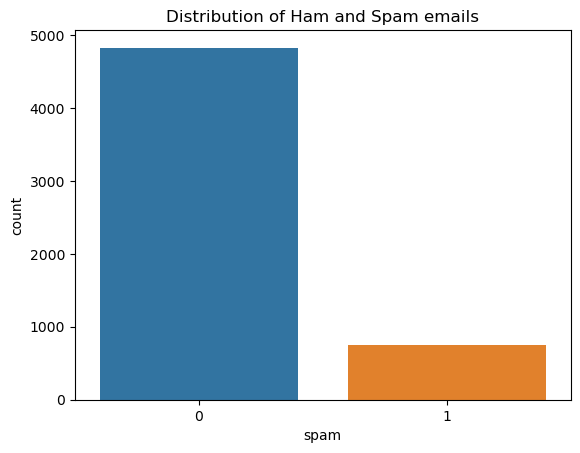

In [119]:
# Plot spams and hams repartition over the dataset
sns.countplot(x="spam", data=df)
plt.title("Distribution of Ham and Spam emails")
plt.show()

The number of spams is clearly lower than the number of hams, it means the dataset is imbalanced.

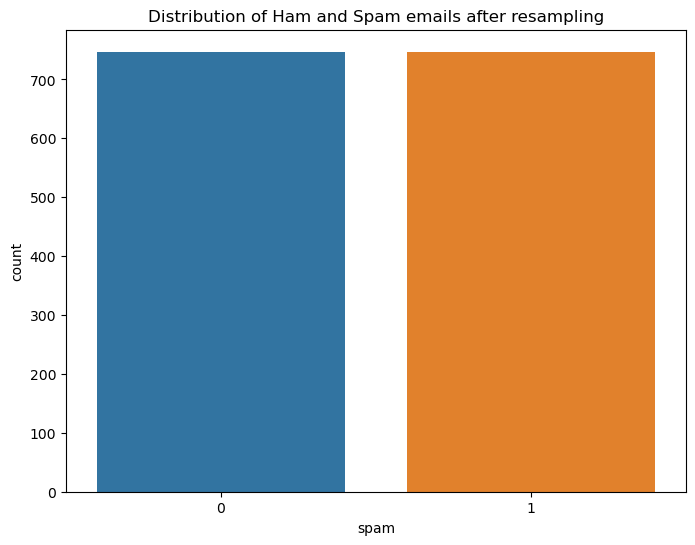

In [121]:
# Downsampling to balance the dataset
ham = df[df["spam"] == 0]
spam = df[df["spam"] == 1]
ham = ham.sample(n=len(spam),random_state=42)
 
# Plotting the counts of down sampled dataset
df_balanced = ham.append(spam).reset_index(drop=True)
plt.figure(figsize=(8, 6))
sns.countplot(data = df_balanced, x="spam")
plt.title('Distribution of Ham and Spam emails after resampling');

### Textual preprocessing

In [122]:
# Remove all non alphanumeric characters except whitespaces and apostrophies
df_balanced["email_text_clean"] = df_balanced["email_text"].apply(lambda x:''.join(ch for ch in x if ch.isalnum() or ch==" " or ch=="'"))

# Remove ponctuation with regexp
df_balanced["email_text_clean"] = df_balanced["email_text_clean"].apply(lambda x: re.sub('[!\"#$%&()*+,-./:;<=>?@\[\]^_`{|}~\\\]+'," ", x)) 

# Remove double spaces and spaces at the beginning and end of strings
df_balanced["email_text_clean"] = df_balanced["email_text_clean"].apply(lambda x: x.replace(" +"," ").strip())

# Remove spaces at the beginning and at the end of the string
df_balanced["email_text_clean"] = [i.strip() for i in df_balanced["email_text_clean"]]

# Remove uppercase
df_balanced["email_text_clean"] = df_balanced["email_text_clean"].fillna('').apply(lambda x: x.lower())

# Remove stop words and replace every word with their lemma
df_balanced["email_text_clean"] = df_balanced["email_text_clean"].apply(lambda x: " ".join([token.lemma_ for token in nlp(x) if (token.lemma_ not in STOP_WORDS) & (token.text not in STOP_WORDS)]))

In [123]:
df_balanced.head()

,spam,email_text,email_text_clean
0,0,"I am late,so call you tomorrow morning.take ca...",be lateso call you tomorrow morningtake care s...
1,0,U r too much close to my heart. If u go away i...,u r too much close to my heart if u go away wi...
2,0,Wait &lt;#&gt; min..,wait ltgt min
3,0,Can you call me plz. Your number shows out of ...,can you call plz your number show out of cover...
4,0,MAYBE IF YOU WOKE UP BEFORE FUCKING 3 THIS WOU...,maybe if you wake up before fucking 3 this wou...


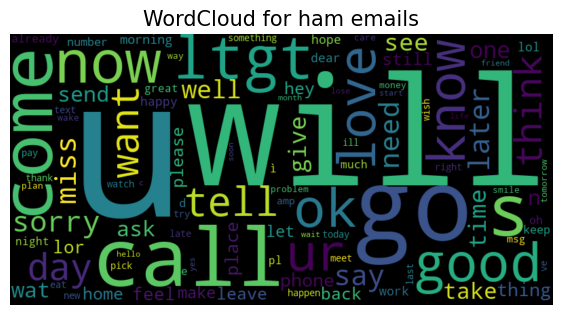

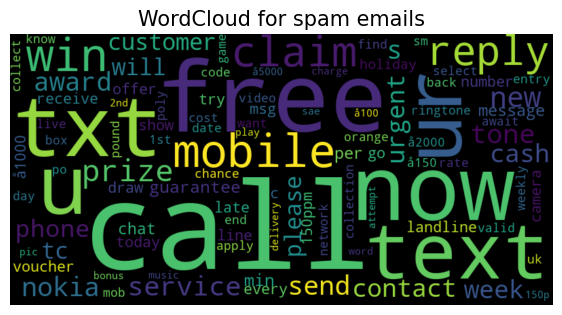

In [124]:
# Plot wordclouds to visualize most common words for spams et hams
def plot_word_cloud(df, typ):
    email_corpus = " ".join(df["email_text_clean"])
 
    plt.figure(figsize=(7, 7))
 
    cloud = WordCloud(background_color="black",
                   max_words=100,
                   width=800,
                   height=400,
                   collocations=False).generate(email_corpus)
 
    plt.imshow(cloud, interpolation="bilinear")
    plt.title(f"WordCloud for {typ} emails", fontsize=15)
    plt.axis("off")
    plt.show()
 
plot_word_cloud(df_balanced[df_balanced["spam"] == 0], typ="ham")
plot_word_cloud(df_balanced[df_balanced["spam"] == 1], typ="spam")

In [125]:
# Instanciate the tokenizer with the number of the most common words to keep
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=1000) 

# The tokenizer lists all unique tokens in the text and associate them with a specific integer
tokenizer.fit_on_texts(df_balanced["email_text_clean"])

# Transform the texts into sequences of indices
df_balanced["email_text_encoded"] = tokenizer.texts_to_sequences(df_balanced["email_text_clean"])

df_balanced.head()

,spam,email_text,email_text_clean,email_text_encoded
0,0,"I am late,so call you tomorrow morning.take ca...",be lateso call you tomorrow morningtake care s...,"[2, 4, 3, 201, 266, 576, 9]"
1,0,U r too much close to my heart. If u go away i...,u r too much close to my heart if u go away wi...,"[7, 95, 267, 284, 514, 1, 24, 368, 47, 7, 32, ..."
2,0,Wait &lt;#&gt; min..,wait ltgt min,"[140, 105, 69]"
3,0,Can you call me plz. Your number shows out of ...,can you call plz your number show out of cover...,"[37, 3, 4, 467, 6, 71, 96, 45, 17, 422, 8, 791..."
4,0,MAYBE IF YOU WOKE UP BEFORE FUCKING 3 THIS WOU...,maybe if you wake up before fucking 3 this wou...,"[666, 47, 3, 370, 53, 304, 792, 115, 31, 173, ..."


In [126]:
# Using padding to add 0 at the end of each sentences in order for all sequences to be of the same length
df_pad = tf.keras.preprocessing.sequence.pad_sequences(df_balanced["email_text_encoded"], padding="post")

df_pad[:2]

array([[  2,   4,   3, 201, 266, 576,   9,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  7,  95, 267, 284, 514,   1,  24, 368,  47,   7,  32, 369,  30,
          2, 467, 577,  21,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,

In [127]:
# Train Test Split, we keep 70% of the dataset for the train set
x_train, x_val, y_train, y_val = train_test_split(df_pad, df_balanced["spam"], test_size=0.3)

In [128]:
# Form tensorflow datasets
train = tf.data.Dataset.from_tensor_slices((x_train, y_train))
val = tf.data.Dataset.from_tensor_slices((x_val, y_val))

In [129]:
# Organize datasets by batches of 64 observations
train_batch = train.shuffle(len(train)).batch(64) # randomly shuffles the elements of this dataset
val_batch = val.batch(64)

### Modeling

In [130]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Embedding, GlobalAveragePooling1D, LSTM, Reshape

In [131]:
# The dimensionality of the representation space
embedding_dim = 32 

# The number of words in the vocabulary
vocab_size = tokenizer.num_words 

model = Sequential([
  Embedding(vocab_size, embedding_dim, name="embedding"), # the input dim needs to be equal to the size of the vocabulary + 1 (because of the zero padding)
  GlobalAveragePooling1D(), # this will pick the average for every word in the sentence along each dimension of the representation space
  Reshape((1, embedding_dim)),
  LSTM(16), # to identify useful patterns in the sequence
  Dense(32, activation="relu"), # a dense layer
  Dense(1, activation="sigmoid") # classification problem so sigmoid
])

# Print the model summary
model.summary()

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 32)          32000     
                                                                 
 global_average_pooling1d_9   (None, 32)               0         
 (GlobalAveragePooling1D)                                        
                                                                 
 reshape_6 (Reshape)         (None, 1, 32)             0         
                                                                 
 lstm_13 (LSTM)              (None, 16)                3136      
                                                                 
 dense_30 (Dense)            (None, 32)                544       
                                                                 
 dense_31 (Dense)            (None, 1)                 33        
                                                     

In [132]:
# Compile the model using adam and the binary cross entropy
model.compile(loss=tf.keras.losses.BinaryCrossentropy(), 
              optimizer="adam", 
              metrics=["accuracy"])

In [133]:
# Train the model on 50 epochs
model_trained = model.fit(
    train_batch,
    validation_data = val_batch,
    epochs = 50
    )

Epoch 1/50
17/17 [==============================] - 2s 27ms/step - loss: 0.6932 - accuracy: 0.5014 - val_loss: 0.6932 - val_accuracy: 0.4744
Epoch 2/50
17/17 [==============================] - 0s 5ms/step - loss: 0.6929 - accuracy: 0.5110 - val_loss: 0.6932 - val_accuracy: 0.4744
Epoch 3/50
17/17 [==============================] - 0s 6ms/step - loss: 0.6925 - accuracy: 0.5110 - val_loss: 0.6930 - val_accuracy: 0.4744
Epoch 4/50
17/17 [==============================] - 0s 5ms/step - loss: 0.6916 - accuracy: 0.5110 - val_loss: 0.6920 - val_accuracy: 0.4744
Epoch 5/50
17/17 [==============================] - 0s 5ms/step - loss: 0.6891 - accuracy: 0.5110 - val_loss: 0.6891 - val_accuracy: 0.4744
Epoch 6/50
17/17 [==============================] - 0s 5ms/step - loss: 0.6829 - accuracy: 0.5110 - val_loss: 0.6822 - val_accuracy: 0.4744
Epoch 7/50
17/17 [==============================] - 0s 5ms/step - loss: 0.6689 - accuracy: 0.5110 - val_loss: 0.6642 - val_accuracy: 0.4788
Epoch 8/50
17/17 [=

### Performances and results

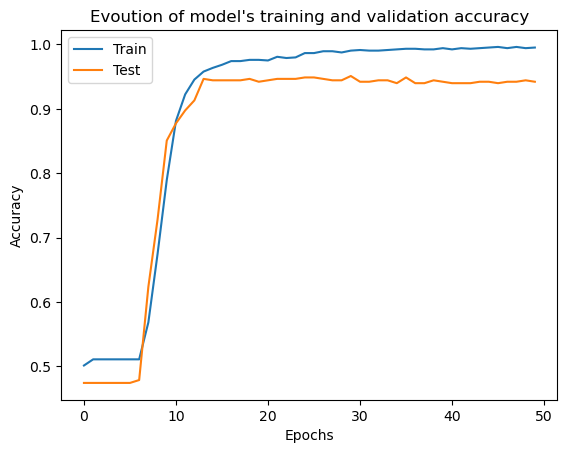

In [134]:
# Visualize the accuray
plt.plot(model_trained.history["accuracy"])
plt.plot(model_trained.history["val_accuracy"])
plt.title("Evoution of model's training and validation accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epochs")
plt.legend(["Train", "Test"], loc="upper left")
plt.show()

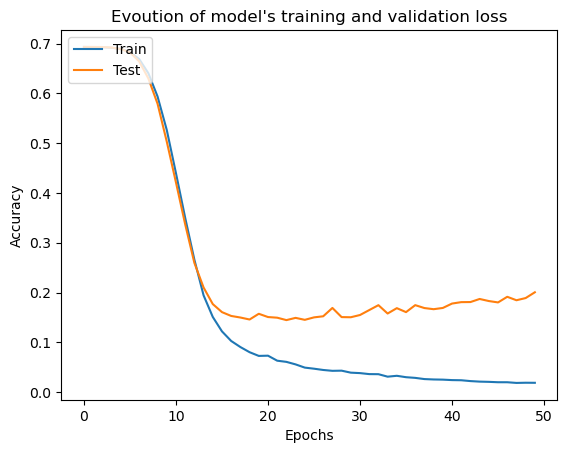

In [135]:
# Visualize the loss
plt.plot(model_trained.history["loss"])
plt.plot(model_trained.history["val_loss"])
plt.title("Evoution of model's training and validation loss")
plt.ylabel("Accuracy")
plt.xlabel("Epochs")
plt.legend(["Train", "Test"], loc="upper left")
plt.show()

15/15 [==============================] - 0s 2ms/step


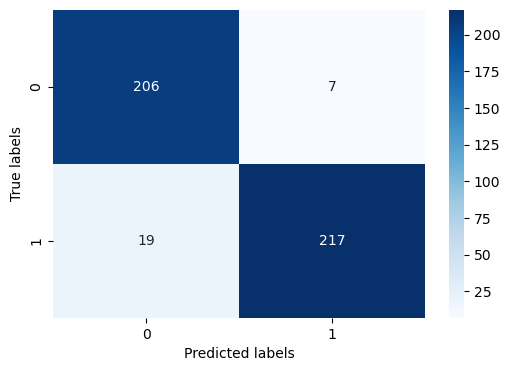

In [136]:
# Visualize the confusion matrix
from sklearn.metrics import confusion_matrix

y_pred = model.predict(x_val)
y_pred = np.round(y_pred).flatten()

# Generate confusion matrix
cm = confusion_matrix(y_val, y_pred)

# Plot the confusion matrix
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.show()

In [137]:
# Precision and recall
from sklearn.metrics import precision_score,recall_score

print("Precision: {:.2f}%".format(100 * precision_score(y_val, y_pred))) # positive predictive value, % of correct predictions on positive predictions
print("Recall: {:.2f}%".format(100 * recall_score(y_val, y_pred))) # sensitivity, 

Precision: 96.88%
Recall: 91.95%
